# Hierarchical Sensor Model</br><small>Localization with an idealized map</small>

In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import bayes3d as b3d
import genjax
from genjax import gen, choice_map, vector_choice_map
import jax
from jax import jit, vmap
import jax.numpy as jnp
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import numpy as np
from genjax._src.core.transforms.incremental import UnknownChange, NoChange, Diff
import trimesh
from xsight.utils import *
from xsight.importance import _importance_sampling
from functools import partial

key = jax.random.PRNGKey(0)
console = genjax.pretty(show_locals=False)

## Making the Map

In [4]:
from xsight.pose import pack_pose, unpack_pose, apply_pose, lift_pose
from xsight.meshes import *
from xsight.plotting import *

fname = "./data/test_env_2d.json"
_segs, _boxes, _xs, _hds, _dxs, _dhds = unpack_2d_env_data(fname)
_verts  = _segs.reshape(-1,2)
_center = np.min(_verts, axis=0) + np.max(_verts, axis=0)/2
_T      = len(_xs)
_segs   = _segs.reshape(-1,2,2)
_boxes  = _boxes.reshape(-1,2,2)
_bb     = bounding_box(_segs)
_ps     = np.concatenate([_xs, _hds[:,None]], axis=1)

_T

50

In [5]:
box_mesh = trimesh.util.concatenate([trimesh_from_2d_segs(box) for box in _boxes.reshape(-1,4,4)])
map_mesh = trimesh_from_2d_segs(_segs.reshape(-1,4))
table = create_cuboid(20, 20, -0.1)
table = move_to_xy(table, *_center)
map_mesh.vertices[:,2] -= 0.5
box_mesh.vertices[:,2] -= 0.5
table.vertices[:,2]    -= 0.5

In [7]:
w = 50
h = 1

near = 0.01
far  = 10.0

fx = 10
fy = 10

cx = w/2 - 0.5
cy = h/2 - 0.5

intrinsics = b3d.Intrinsics(
    height = h,
    width  = w,
    fx=fx, fy=fy,
    cx=cx, cy=cy,
    near=near, far=far
)
b3d.setup_renderer(intrinsics)
b3d.RENDERER.add_mesh(trimesh.util.concatenate([map_mesh, table]), center_mesh=False)
b3d.RENDERER.add_mesh(box_mesh, center_mesh=False)


def render(p, inds=[0,1]):
    p_ = b3d.t3d.inverse_pose(p)
    X  = b3d.RENDERER.render(jnp.tile(p_, (len(inds),1,1)), jnp.array(inds))
    return X;

Increasing frame buffer size to (width, height, depth) = (64, 32, 1024)


[E rasterize_gl.cpp:121] OpenGL version reported as 4.6


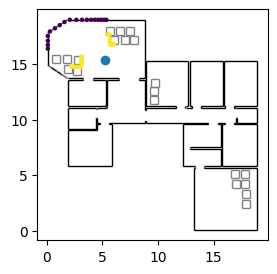

In [9]:
t  = 40
p  = _ps[t]
X  = render(lift_pose(p[:2], p[2]), inds=[0,1])
xs = X[0][:,[0,2]]
xs = apply_2dpose(p, xs)


# ---------------------------------
plt.figure(figsize=(3,3))
plt.gca().set_aspect(1)
plot_segs(_segs, c="k", zorder=-1)
plot_segs(_boxes, c="gray", zorder=-1)
plt.scatter(*_ps[t][:2], marker="o")
plt.scatter(*xs.T,c=X[0,:,3], vmin=1, vmax=2, s=5)

## Making the model

[<matplotlib.lines.Line2D object at 0x7f717054b790>]

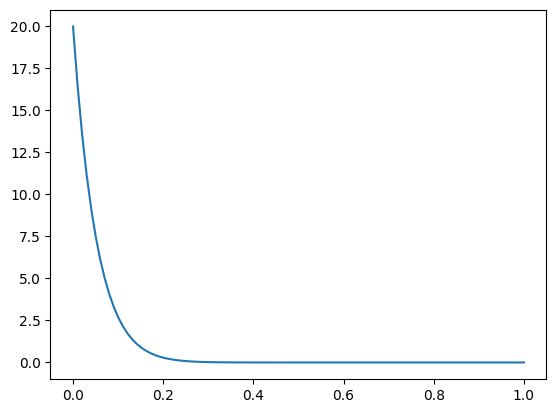

In [309]:
xs = jnp.linspace(0,1,100)
ys = vmap(lambda x: genjax.beta.logpdf(x, 1, 20))(xs)
plt.plot(xs,jnp.exp(ys))

In [240]:
from genjax import tfp_uniform as uniform
from xsight.likelihood import make_constrained_sensor_model, make_baseline_sensor_model


def make_sensor_model(w:int, zmax:float, sensor_model_type:str):
    match sensor_model_type:
        case "constrained":
            return make_constrained_sensor_model(zmax, w)

        case "baseline":
            return make_baseline_sensor_model(zmax, w)

        case _:
            raise f"Unknown sensor model type: ``{sensor_model_type}''"


def make_model(w:int, zmax:float, sensor_model_type:str):

    # Create a sensor model
    sensor_model = make_sensor_model(w, zmax, sensor_model_type)

    @gen
    def model(inds, beta=jnp.array([1.0,1.0])):

        x  = uniform(jnp.array([0., 0.]), jnp.array([20., 20.])) @ "x"
        hd = uniform(-jnp.pi, jnp.pi) @ "hd"
        
        # Sample Hyper Parameters
        # sig     = uniform(0.0, 1.) @ "sig"
        sig     = genjax.beta(*beta) @ "sig"
        outlier = uniform(0.0, 1.) @ "outlier"

        # Lift pose to 3D and 
        # render an image (deterministic)
        Y = render(lift_pose(x, hd), inds)

        # Sample X conditioned on Y
        # Here `inline` populates address "X"
        X, _ = sensor_model.inline(Y[:,:,:3], sig, outlier) 

        return pack_2dpose(x, hd), X[0][:,[0,2]]
    
    return model


In [228]:
def plot_tr(tr, ax=None, title=""):
    
    if ax is None:
        plt.figure(figsize=(5,5))
        ax=plt.gca()

    p, xs = tr.get_retval()

    # ---------------------------------------------------------
    if len(title) > 0: title = f"{title}\n"
    ax.set_title(f"{title}score = {tr.get_score():0.2f}\nsig = {tr['sig']:0.2f}\nout = {tr['outlier']:0.2f}")
    ax.set_aspect(1)
    plot_segs(_segs, c="k", zorder=1)
    plot_segs(_boxes, c="gray", zorder=1)
    ax.scatter(*apply_2dpose(p, xs).T, s=10, zorder=2)
    plot_pose(p, r=.5, zorder=3)

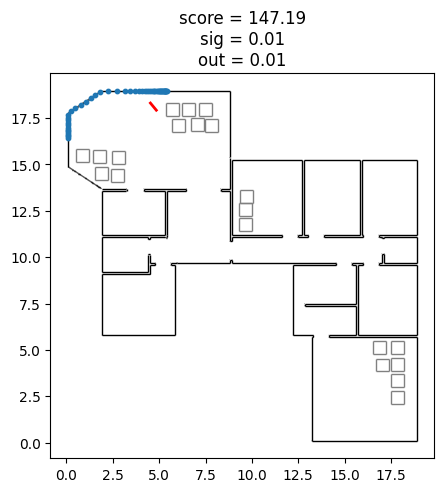

In [229]:
w     = 5
zmax  = 10.0

sensor_model_type = ["constrained", "baseline"][0]
model = make_model(w, zmax, sensor_model_type)

key   = keysplit(key)
_, tr = model.importance(key, genjax.choice_map({"sig": 0.01, "outlier": 0.01}), (jnp.array([0,1]),))

# ========================================
plot_tr(tr, ax=None, title="")

In [230]:
def make_constraints(X, sensor_model_type):
    X  = X[:,:,:3].reshape(-1,3)
    D  = jnp.linalg.norm(X, axis=-1)
    ch = genjax.choice_map({"X": 
            genjax.vector_choice_map({
                "measurement":  D if sensor_model_type == "constrained" else X
            }) 
    })
    return ch

In [231]:
def get_data_logprobs(tr):
    pixel_addr = lambda i: genjax.select({"X":
        genjax.index_select(i,  genjax.select("measurement"))
    })
    inds  = jnp.arange(tr["X", "measurement"].shape[0])
    logps = vmap(lambda i: tr.project(pixel_addr(i)))(inds)
    return logps

In [232]:
def _eval_pose_and_sensor(tr, key, p, sig, outlier):
    ch = choice_map({
        'x':  p[:2], 
        'hd': p[ 2],
        'sig':     sig,
        'outlier': outlier,
    })
    diffs = argdiffs(tr.args)
    (_, w, tr_, _) = tr.update(key, ch, diffs)
    log_ps = get_data_logprobs(tr_)
    return tr_.get_score(), log_ps


eval_pose_and_sensor = jax.jit(jax.vmap(_eval_pose_and_sensor, in_axes=(None, None, 0, 0, 0)))

## Perturbing the Trace

We create a bunch of traces that could have created in a particle filter update. However we are just perturbing the ground truth pose.

In [180]:
@genjax.gen
def anchored_pose_prior(p, sig_x=0.5, sig_hd=10):
    
    sig_hd = sig_hd/180*jnp.pi

    x  = genjax.tfp_normal(p[:2], sig_x*jnp.ones(2)) @ "x"
    hd = genjax.tfp_normal(p[2], sig_hd)             @ "hd"

    q  = pack_2dpose(x, adjust_angle(hd))
    
    return q

In [181]:
# Get true pose and observations
t0 = 40
p0 = _ps[t0]

X0 = render(lift_pose(p0[:2], p0[2]), inds=[0,1])
xs = X0.reshape(-1,4)[:,[0,2]]

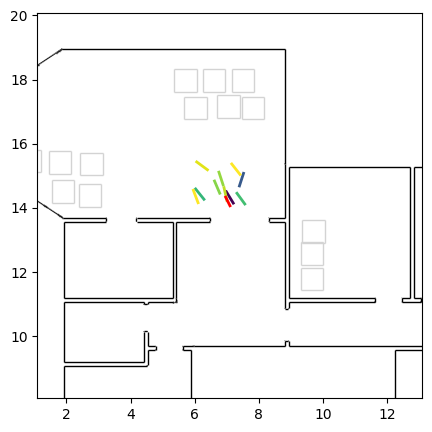

In [256]:
w     = 7
zmax  = 10.
sensor_model_type = ["constrained", "baseline"][1]

model = make_model(w, zmax, sensor_model_type)
obs   = make_constraints(X0, sensor_model_type)

N     = 10
key   = keysplit(key)
(trs, ws, _) = _importance_sampling(key,
                                    model, (jnp.array([0]),), obs,  
                                    anchored_pose_prior, (p0, .5, 15), 
                                    N=N)


ps = jnp.concatenate([trs["x"], trs["hd"][:,None]], axis=-1)
sc = trs.get_score()
# -----------------------
plt.figure(figsize=(5,5))
PAD = 6; 
zoom_in(p0[:2], PAD)
plot_segs(_segs, c="k", zorder=1)
plot_segs(_boxes, c="lightgray", zorder=1)
plot_poses(ps, sc, r=0.5)
plot_pose(p0, r=0.3, linewidth=2)

## The Grid

In [257]:
def get_linear_grid(shape, bounds, flat=False):
    n = len(shape)
    vs = jnp.stack(jnp.meshgrid(
        *[jnp.linspace(*b, d) for b,d in zip(bounds, shape)],
    indexing='ij'), axis=-1)

    if flat: vs = vs.reshape(-1,len(shape))
    
    return vs


def make_inference_grid(tr, shape, dx, dhd, sig=(0.01, 0.5), outlier=(0.001, 0.5)):
    args  = (
        (tr['x'][0]-dx,tr['x'][0]+dx),
        (tr['x'][1]-dx,tr['x'][1]+dx),
        (tr['hd']-dhd,tr['hd']+dhd),
        sig,
        outlier,
    )
    return get_linear_grid(shape, args)

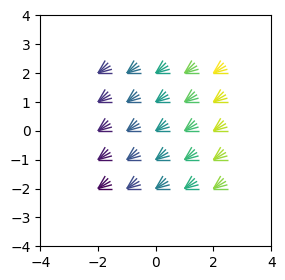

In [258]:
vs = get_linear_grid((5, 5, 5), ((-2,2), (-2,2), (0,jnp.pi/3)), flat=True)
sc = jnp.arange(len(vs))

# =======================================
plt.figure(figsize=(3,3))
zoom_in(vs[:,:2], 2)
plot_poses(vs, sc, linewidth=1)

In [259]:
def pose_error(p, q):
    d = p - q
    d = d.at[2].set(adjust_angle(d[2]))
    return jnp.linalg.norm(d)

## Experiment

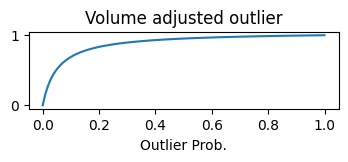

In [260]:
w     = 5
zmax  = 20.
vol   = 1
out   = .2

# This is relevant to map between Nishad's version and mine.
def volume_adjust(out, zmax, vol):
    """Gives w' such that we have (1-w)p + w/zmax = (1-w')p + w'/vol."""
    return (out*zmax/vol)/(1- out + out*zmax/vol)


# -------------
outls = jnp.linspace(0,1,100)
plt.figure(figsize=(4,1))
plt.title("Volume adjusted outlier")
plt.plot(outls, vmap(partial(volume_adjust, zmax=zmax, vol=vol))(outls))
plt.xlabel("Outlier Prob.")

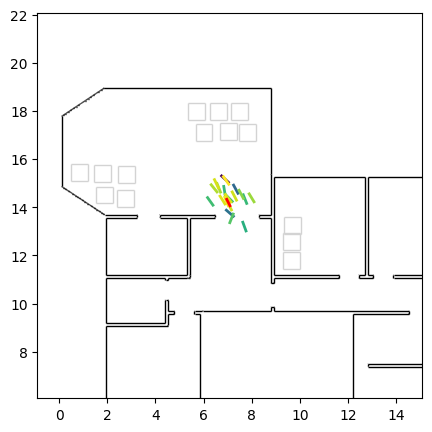

In [336]:
# Get true pose and observations
t0 = 35
p0 = _ps[t0]

X0 = render(lift_pose(p0[:2], p0[2]), inds=[0,1])
xs = X0[:,:,:3].reshape(-1,3)[:,[0,2]]


w     = 11
zmax  = 10.
sensor_model_type = ["constrained", "baseline"][0]

model = make_model(w, zmax, sensor_model_type)
obs   = make_constraints(X0, sensor_model_type)
args  = (jnp.array([0]), jnp.array([1., 1.]))
N     = 20
key   = keysplit(key)
(trs, ws, _) = _importance_sampling(key,
                                    model, args, obs,  
                                    anchored_pose_prior, (p0, .5, 15), 
                                    N=N)


ps = jnp.concatenate([trs["x"], trs["hd"][:,None]], axis=-1)
sc = trs.get_score()
# ==========================================
plt.figure(figsize=(5,5))

PAD = 8; 
zoom_in(p0[:2], PAD)
plot_segs(_segs, c="k", zorder=1)
plot_segs(_boxes, c="lightgray", zorder=1)
plot_poses(ps, sc, r=0.5)
plot_pose(p0, r=0.3, linewidth=2)

In [337]:
exp_id = 2

ps = jnp.load(f"data/hierarchical_bayes_#1_t{t0}_ps.npy")
trs = vmap(lambda tr,p: tr.update(
                    key, 
                    choice_map({"x": p[:2], "hd": p[2]}), 
                    argdiffs(args))[2])(trs, ps)

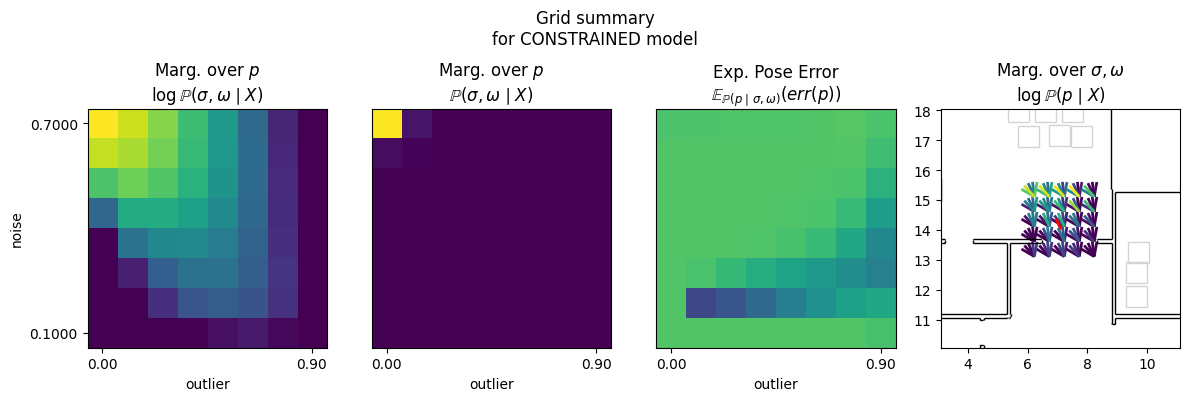

In [338]:
# Plot function for grid summary
i = 0
tr = trs.slice(i)

dx  = 1.
dhd = 35/180*jnp.pi
shape = (5,5,5, 8,8)
VOL = zmax

# Grid
vs = make_inference_grid(tr, shape, 
                dx, dhd,  
                sig     = (0.1, 0.7), 
                outlier = (0.0, 0.9))
vs_flat = vs.reshape(-1, len(shape))

# Eval Grid
key   = keysplit(key)
outls = vmap(volume_adjust, (0,None, None))(vs_flat[:,4], zmax, VOL)

sc_flat, logps = eval_pose_and_sensor(tr, key, vs_flat[:,:3], vs_flat[:,3], outls)

sc    = sc_flat.reshape(shape)
logps = logps.reshape(shape + (tr["X", "measurement"].shape[0],))



def plot_grid_summary(vs, sc, shape):

    vs_flat = vs.reshape(-1, len(shape))
    sc_flat = sc.reshape(-1)


    # Marginalize out poses
    sc_marg  = logsumexp(sc, axis=(0,1,2))
    sc_marg  = sc_marg - logsumexp(sc_marg)
    sc_marg_ = jnp.clip(sc_marg, jnp.quantile(sc_marg, 0.25), jnp.max(sc_marg))

    # Expected Pose Error
    err_flat = vmap(partial(pose_error, p0))(vs.reshape(-1,len(shape))[:,:3])
    err      = err_flat.reshape(shape)
    pr       = jnp.exp(sc - logsumexp(sc, axis=(0,1,2)))
    mean_err = jnp.sum(pr*err, axis=(0,1,2))

    # =================================================
    fig, axs = plt.subplots(1,4,figsize=(12,4))
    plt.suptitle(f"Grid summary\nfor {sensor_model_type.upper()} model")
    axs[0].set_title("Marg. over $p$\n$\log \mathbb{P}(\sigma, \omega \mid X)$")
    axs[0].imshow(sc_marg_, origin='lower')
    axs[0].set_xticklabels(vs[0,0,0,0,:1,4])
    axs[0].set(
        xlabel="outlier",
        xticks=[0, shape[4]-1], 
        xticklabels=[f"{v:0.2f}" for v in vs[0,0,0,0,[0, shape[4]-1],4]],
        ylabel="noise",
        yticks=[0, shape[3]-1], 
        yticklabels=[f"{v:0.4f}" for v in vs[0,0,0,[0, shape[3]-1],0,3]],
    )

    axs[1].set_title("Marg. over $p$\n$\mathbb{P}(\sigma, \omega \mid X)$")
    axs[1].imshow(jnp.exp(sc_marg), vmin=0.0, origin='lower')
    axs[1].set(
        xlabel="outlier",
        xticks=[0, shape[4]-1], 
        xticklabels=[f"{v:0.2f}" for v in vs[0,0,0,0,[0, shape[4]-1],4]],
        yticks=[],
    )

    axs[2].set_title("Exp. Pose Error\n$\mathbb{E}_{\mathbb{P}(p \mid \sigma, \omega)} ( err(p) )$")
    axs[2].imshow(mean_err, vmin=jnp.min(err), vmax=jnp.max(err), cmap="viridis", origin='lower')
    axs[2].set(
        xlabel="outlier",
        xticks=[0, shape[4]-1], 
        xticklabels=[f"{v:0.2f}" for v in vs[0,0,0,0,[0, shape[4]-1],4]],
        yticks=[],
    );


    plt.subplot(1,4,4)
    ax = plt.gca()
    ax.set_title("Marg. over $\sigma, \omega$\n$\log \mathbb{P}(p \mid X)$")
    vs_ = vs[:,:,:,0,0].reshape(-1,len(shape))
    sc_ = logsumexp(sc, axis=(3,4)).reshape(-1)
    PAD = 4; 
    zoom_in(p0[:2], PAD)
    plot_segs(_segs, c="k", zorder=1)
    plot_segs(_boxes, c="lightgray", zorder=1)
    plot_poses(vs_[:,:3], sc_.reshape(-1), r=0.5, q=0.3)
    plot_pose(p0, r=0.3, linewidth=2)
    
    fig.tight_layout()


plot_grid_summary(vs, sc, shape)

**Notation:**
- $p=(x, \theta)$ &mdash; Pose
- $\sigma$ &mdash; Sensor noise
- $\omega$ &mdash; Outlier probability

**Marginal Probability:**

We define $\mathbb{P}(p, \sigma, \omega \mid X) \propto \textup{e}^{\text{sc}(p, \sigma, \omega \mid X)}$ and integrate out the hyper parameters to get the marginal
$$
    \mathbb{P}(\sigma, \omega \mid X)  = \int_{\sigma, \omega} \mathbb{P}(p, \sigma, \omega \mid X) \ d\sigma d\omega
$$ 

**Expected pose error:**

We define the error $\text{err}(p) = \text{err}(p, p_0)$ of a pose $p$ as its Euclidean distance to the ground truth $p_0$, i.e. $\text{err}(p) = \| p - p_0 \|$  &mdash; here we identify the head direction with an element in $\mathbb{R}/2\pi\mathbb{R}$ and use its induced norm. The expected pose error $\text{err}(\sigma, \omega)$ for a given pair $(\sigma,\omega)$ is given by
$$
    \text{err}(\sigma, \omega) := \mathbb{E}_{\ p \ \sim \ \mathbb{P}( . \mid \sigma, \omega; X )}\big[ \text{err}(p)   \big].
$$

**How to read and parse the figure:**

- **Subfigures 1-3:** The probability mass of the marginal $\mathbb{P}(\sigma, \omega \mid X)$ should be concentrated in low error regions of $\text{err}(\sigma, \omega)$.
- **Subfigure 4:** The probability mass of the marginal $\mathbb{P}(p \mid X)$ should be close to the ground truth pose $p_0$ plotted in red.

In [339]:
from ipywidgets import interact, IntSlider, FloatSlider, FloatRangeSlider


vs = None
sc = None
shape = None
logps = None
@interact(
        i = IntSlider(min=0, max=N-1, step=1, value=0, continuous_update=False, description="trace:"),
        num_x   = IntSlider(min=0, max=15, step=1, value=5, continuous_update=False),
        num_hd  = IntSlider(min=0, max=15, step=1, value=5, continuous_update=False),
        num_sig = IntSlider(min=0, max=15, step=1, value=5, continuous_update=False),
        num_out = IntSlider(min=0, max=15, step=1, value=5, continuous_update=False),
        sig = FloatRangeSlider(min=1e-6, max=1.0, step=0.01, value=[0.05,0.7], continuous_update=False),
        out = FloatRangeSlider(min=0, max=1.0, step=0.01, value=[0.0,0.7], continuous_update=False),
        VOL = FloatSlider(min=0.001, max=150., step=0.01, value=zmax, continuous_update=False),
)
def func(i, num_x, num_hd, num_sig, num_out, sig, out, VOL):
        
        global key;
        global vs, sc, shape, logps;
        
        tr = trs.slice(i)

        # Grid config
        dx  = 1.
        dhd = 35/180*jnp.pi
        shape = (num_x, num_x, num_hd, num_sig, num_out)

        # Grid
        vs = make_inference_grid(tr, shape, dx, dhd, sig = sig, outlier = out)
        vs_flat  = vs.reshape(-1, len(shape))
        
        # Eval Grid
        key = keysplit(key)
        outls = vmap(volume_adjust, (0,None, None))(vs_flat[:,4], zmax, VOL)
        sc_flat, logps = eval_pose_and_sensor(tr, key, vs_flat[:,:3], vs_flat[:,3], outls)
        sc = sc_flat.reshape(shape)
        logps = logps.reshape(shape + (tr["X", "measurement"].shape[0],))

        # Plot summary
        plot_grid_summary(vs, sc, shape)

interactive(children=(IntSlider(value=0, continuous_update=False, description='trace:', max=19), IntSlider(val…

In [340]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import (interact, interactive, FloatSlider, IntSlider, 
        Button, Output, HBox, VBox, FloatRangeSlider, Layout, Checkbox, RadioButtons)
from ipywidgets.embed import embed_minimal_html

def func(i, j, k0, k1, sorted_by):


        global key;
        global vs, sc, shape, logps;
        
        vs_flat = vs.reshape(-1, len(shape))
        sc_flat = sc.reshape(-1)

        # Marginalize out poses
        sc_marg  = logsumexp(sc, axis=(0,1,2))
        sc_marg  = sc_marg - logsumexp(sc_marg)
        sc_marg_ = jnp.clip(sc_marg, jnp.quantile(sc_marg, 0.5), jnp.max(sc_marg))

        # Expected Pose Error
        err_flat = vmap(partial(pose_error, p0))(vs.reshape(-1,len(shape))[:,:3])
        err      = err_flat.reshape(shape)
        pr       = jnp.exp(sc - logsumexp(sc, axis=(0,1,2)))
        mean_err = jnp.sum(pr*err, axis=(0,1,2))

        
        vs_    =    vs[:,:,:,i,j].reshape(-1,len(shape))
        sc_    =    sc[:,:,:,i,j].reshape(-1)
        logps_ = logps[:,:,:,i,j].reshape(-1, logps.shape[-1])
        err_   =   err[:,:,:,i,j].reshape(-1)
        
        order0 = jnp.argsort(sc_)[::-1]
        order1 = jnp.argsort(err_)
        k = k0 if sorted_by=="score" else k1
        order = order0 if sorted_by=="score" else order1

        is_outlier = jnp.exp(logps_[order[k]]) < 2*vs_[order[k],4]/zmax


        a = vs_[:,:2]
        b = a + 0.4 * jax.vmap(unit_vec)(vs_[:,2])

        center = (vs_[0,:2] + vs_[-1,:2])/2
        sc_ = jnp.clip(sc_, jnp.quantile(sc_, 0.6), jnp.max(sc_))
        cs = plt.cm.viridis(plt.Normalize()(sc_))

        # =====================================
        fig, axs = plt.subplots(2, 4, figsize=(12,12), 
                width_ratios  = [1, 1, 1, 1], 
                height_ratios = [1, 3],
        )
        
        plt.suptitle(f"Grid summary\nfor {sensor_model_type.upper()} model")

        ######
        ######
        ax = axs[0,0]
        ax.set_title("$\log \mathbb{P}(\sigma, \omega \mid X)$")
        ax.imshow(sc_marg_, origin='lower')
        ax.set_xticklabels(vs[0,0,0,0,:1,4])
        ax.set(
                xlabel="outlier",
                xticks=[0, shape[4]-1], 
                xticklabels=[f"{v:0.2f}" for v in vs[0,0,0,0,[0, shape[4]-1],4]],
                ylabel="noise",
                yticks=[0, shape[3]-1], 
                yticklabels=[f"{v:0.4f}" for v in vs[0,0,0,[0, shape[3]-1],0,3]],
        )
        ax.scatter(j,i,c="red")


        ######
        ######
        ax = axs[0,1] 
        ax.set_title("$\mathbb{E}_{\mathbb{P}(p \mid \sigma, \omega)} ( err(p) )$")
        ax.imshow(mean_err, vmin=jnp.min(err), vmax=jnp.max(err), cmap="viridis", origin='lower')
        ax.set(
                xlabel="outlier",
                xticks=[0, shape[4]-1], 
                xticklabels=[f"{v:0.2f}" for v in vs[0,0,0,0,[0, shape[4]-1],4]],
                yticks=[],
        );
        ax.scatter(j,i,c="red");


        ######
        ######
        gs = axs[0, 2].get_gridspec()
        axs[0,2].remove()
        axs[0,3].remove()
        ax = fig.add_subplot(gs[0,2:])
        ax.set_title("Pixel Probs")
        
        ax.plot(jnp.exp(logps_[order[k]]), marker="o")
        ax.set(
                xlabel="Pixel",
                ylim=(-0.1,jnp.max(jnp.exp(logps_[order[k]]))+0.2)
        );


        ######
        ######
        gs = axs[1, 0].get_gridspec()
        axs[1,0].remove()
        axs[1,1].remove()
        ax = fig.add_subplot(gs[1,:2])
        ax.set_title("Pose scores and outliers")
        ax.set_aspect(1)
        plot_segs(_segs, c="k", zorder=1)
        plot_segs(_boxes, c="lightgray", zorder=1)
        zoom_in(center, 7)
        ax.plot(*jnp.stack([p0[:2], p0[:2] + 0.2*unit_vec(p0[2])], axis=1), 
                c="r", zorder=4, linewidth=2)

        ax.add_collection(line_collection(a[order0[::-1]],b[order0[::-1]], c=cs[order0[::-1]], zorder=1, linewidth=3));

        o_ = jnp.argsort(logps_[order[k]])
        # ax.scatter(*apply_2dpose(vs_[order[k],:3], xs[o_]).T, s=100, c=jnp.exp(logps_[order[k]][o_]))
        ax.scatter(*apply_2dpose(vs_[order[k],:3], xs[is_outlier==False]).T, s=60, c="blue")
        ax.scatter(*apply_2dpose(vs_[order[k],:3], xs[is_outlier==True]).T, s=40, c="red")


        ######
        ######
        gs = axs[1, 2].get_gridspec()
        axs[1,2].remove()
        axs[1,3].remove()
        ax = fig.add_subplot(gs[1,2:])
        ax.set_title("Inferred pose and pixel probs")
        ax.set_aspect(1)
        plot_segs(_segs, c="k", zorder=1)
        plot_segs(_boxes, c="lightgray", zorder=1)
        zoom_in(center, 7)
        ax.add_collection(line_collection(a[order0[::-1]],b[order0[::-1]], c="lightgray", zorder=1, linewidth=1));
        plot_pose(p0, r=0.3, c="r", zorder=3)
        plot_pose(vs_[order[k],:3], r=0.3, c="b", zorder=4)
        ax.scatter(*apply_2dpose(vs_[order[k],:3], xs[o_]).T, s=40, c=jnp.exp(logps_[order[k]][o_]), cmap="plasma")


        ######
        ######
        fig.tight_layout()



w = interactive(func, 
    i = IntSlider(min=0, max=shape[3]-1, step=1, value=0, continuous_update=False, description='sig:'),
    j = IntSlider(min=0, max=shape[4]-1, step=1, value=0, continuous_update=False, description='out:'),
    k0 = IntSlider(min=0, max=np.prod(shape[:3])-1, step=1, value=0, continuous_update=False, description='i score:'),
    k1 = IntSlider(min=0, max=np.prod(shape[:3])-1, step=1, value=0, continuous_update=False, description='i err:'),
    sorted_by = RadioButtons(options=['score', 'err'],value='score', description='Sorted by:',disabled=False)
);


w

interactive(children=(IntSlider(value=0, continuous_update=False, description='sig:', max=4), IntSlider(value=…

In [ ]:
import json


exp_id = 0
ps = jnp.concatenate([trs["x"], trs["hd"][:,None]], axis=-1)
jnp.save(f"data/hierarchical_bayes_#{exp_id}_t{t0}_ps", ps)
fname = f"data/hierarchical_bayes_#{exp_id}.json"
with open(fname, "w") as f:
    f.write(json.dumps(dict(t0= t0,ps = np.array(ps).tolist())))